In [25]:
!pip install imutils
#importing required libraries
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import imutils
from sklearn import svm

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

You should consider upgrading via the 'c:\users\dell\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
#loading the images into the notebook
#from google.colab import files
#files.upload()

In [3]:
images="Painting Dataset/Train images/"

In [4]:
image_list = []
image_cat = []
categories = ["VanGohg" , "Not"]
for i in range(1,34):
  #looping through images and converting to jpg
    image=Image.open(images+ str(i)+'.jpg')
    #resizing the image
    image=image.resize((400, 400))
    #appending to the list
    image_list.append(np.asarray(image))
    cat_num = categories.index(categories[0]) 
    image_cat.append(cat_num)

for i in range(34,67):
  #looping through images and converting to jpg
    image=Image.open(images+ str(i)+'.jpg')
    #resizing the image
    image=image.resize((400, 400))
    #appending to the list
    image_list.append(np.asarray(image))
    cat_num = categories.index(categories[1]) 
    image_cat.append(cat_num)

#appending to array
images = np.array(image_list)
image_cat = np.array(image_cat)

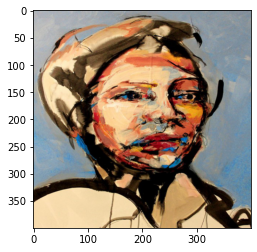

In [5]:
plt.imshow(images[50])

In [24]:
#extracting features
kp_img=[]
for i in range(66):
  #grayscaling images
  grayimg = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
  #initiating ORB detector
  orb = cv2.ORB_create(nfeatures=1000)
  #finding keypoints and detectors for both images
  kpt, desc = orb.detectAndCompute(grayimg,None)

  #storing the descriptor in a dict
  #desc_list = {}
  #desc_list.setdefault(i,[]).append(desc)
  #print(desc_list)
  #kp_list = {}
  #kp_list.setdefault(i,[]).append(kpt)

  img = cv2.drawKeypoints(grayimg, kpt, None)
  kp_img.append(np.asarray(img))

  #print(kp_list)
features = np.array(kp_img)
#print(features)

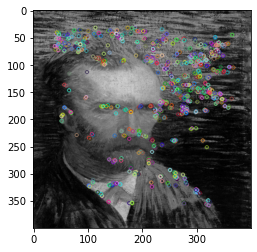

In [7]:
plt.imshow(features[10])

In [21]:
#making training dataset
X = features
y = image_cat

(66, 400, 400, 3)

In [14]:
#reshapnig X for SVM
#X_2d = X.reshape(66,-1)

In [19]:
#normalizing the dataset
X = utils.normalize(X, axis=1)
X.shape

(66, 400, 400, 3)

In [16]:
#assert not np.any(np.isnan(X))

In [17]:
#splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#Test Case

In [37]:
#preprocessing the test image
test_img = load_img("Painting Dataset/Train images/16.jpg",target_size=(400, 400))


#finding keypoints and detectors for both images
kp_img=[]
test_img= np.asarray(test_img)
grayimg = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=1000)

kpt, desc = orb.detectAndCompute(grayimg,None)
img = cv2.drawKeypoints(grayimg, kpt, None)
kp_img.append(np.asarray(img))
X_test = np.array(kp_img)
X_test= utils.normalize(X_test, axis=1)

#Building Model

In [17]:
#building a seq2seq model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(400,400,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='Same',activation='relu', kernel_initializer = 'he_uniform'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dense(1, activation='sigmoid'))

#defining the batch sizes and epochs
batch_size = 30
epochs = 40
opt = SGD()

In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=50)

In [19]:
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 398, 398, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 199, 199, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 199, 199, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 99, 99, 128)       7

In [ ]:
#training the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    verbose=1, validation_data=(X_test, y_test), callbacks = [early_stop])

In [22]:
#evaluating model over test dataset
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.2857


[0.7122893333435059, 0.2857142984867096]

In [26]:
model.save("paintings.h5")

In [38]:
#loading the model in the notebook
model = load_model('paintings.h5')

In [39]:
prediction=model.predict(X_test)
print(prediction)

[[0.2210573]]


In [40]:
predictedClass = prediction.argmax(axis=-1)
print(predictedClass)

[0]


#Prediction

In [24]:
pred = model.predict_classes(X_test)
preds_img = [X_test,pred,y_test]
for i in range(7):
  print("Image index:", i, "Predicted label:", preds_img[1][i], "Original label:", preds_img[2][i])

Image index: 0 Predicted label: [0] Original label: 1
Image index: 1 Predicted label: [0] Original label: 1
Image index: 2 Predicted label: [1] Original label: 0
Image index: 3 Predicted label: [0] Original label: 1
Image index: 4 Predicted label: [0] Original label: 0
Image index: 5 Predicted label: [0] Original label: 1
Image index: 6 Predicted label: [0] Original label: 0


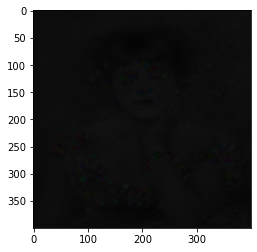

In [25]:
plt.imshow(preds_img[0][1])